## Introduction
>Many people around the world suffer from a heart attack.A heart attack, also called a myocardial infarction, happens when a part of the heart muscle doesn’t get enough blood.The more time that passes without treatment to restore blood flow, the greater the damage to the heart muscle.Machine learning algorithms can predict a heart attack early, so we will be able to treat the patient early and avoid death due to a heart attack, and this is what we will do in this project.

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from empiricaldist import Pmf , Cdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
spark = SparkSession.builder\
                    .appName('first_spark_application') \
                    .getOrCreate()

In [3]:
df = spark.read.csv('heart.csv' , header = True , inferSchema = True)
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|

| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|

| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|

| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|

| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|

| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|

| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|

| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|

| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    

In [4]:
#rename the target column to label column 
df = df.withColumnRenamed("target","label")

In [5]:
df.printSchema()

root

 |-- age: integer (nullable = true)

 |-- sex: integer (nullable = true)

 |-- cp: integer (nullable = true)

 |-- trestbps: integer (nullable = true)

 |-- chol: integer (nullable = true)

 |-- fbs: integer (nullable = true)

 |-- restecg: integer (nullable = true)

 |-- thalach: integer (nullable = true)

 |-- exang: integer (nullable = true)

 |-- oldpeak: double (nullable = true)

 |-- slope: integer (nullable = true)

 |-- ca: integer (nullable = true)

 |-- thal: integer (nullable = true)

 |-- label: integer (nullable = true)




In [6]:
def label_graph(ticksfont , x_label , y_label , title_label , fontsize):
    
    plt.xticks(fontsize = ticksfont)
    plt.yticks(fontsize = ticksfont)

    plt.xlabel(x_label, fontsize = fontsize)
    plt.ylabel(y_label , fontsize = fontsize)
    plt.title(title_label, fontsize = fontsize)

If we want to visualize our data to help us understand and analyze it, we can use different libraries such as Seaborn, matplotlib and other libraries, but these libraries cannot be used directly with pyspark dataframes.

So there are three different methods:
- **pyspark_dist_explore :** library provides quick insights into Dataframes. currently have three functions 
`hist()` , `distplot()` , `pandas_histogram()`

- **toPandas** : we convert pyspark dataframe to pandas dataframe to create charts using matplotlib and seaborn easliy

- **HendySpark** : is a package designed to improve PySpark user experience

we will use toPandas to visualize our data 

In [48]:
panda_df = df.toPandas()
panda_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


`cp` is an abbreviation for chest pain type (4 values)

So, if we want to know what is the probability of a person having a heart attack if chest pain type is 2 or 3
in this situation we can use PMFs

#### What is Probability Mass Functions (PMFs) :
**probability mass functions (PMFs)** used to represent a distribution , which maps from each value to its probability. A probability is a frequency expressed as a fraction of the sample size, n. To get from frequencies to probabilities, we divide through by n, which is called normalization . It is used with disceret variable

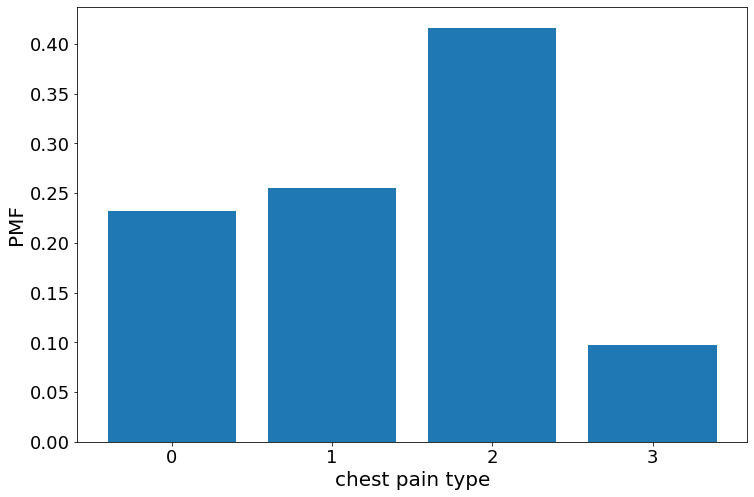

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

heart_attack = panda_df[panda_df['label'] == 1]
pmf = Pmf.from_seq(heart_attack['cp'])
pmf.bar()

#convert x-axis from float to integer
plt.locator_params(integer = True)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('chest pain type', fontsize = 20)
plt.ylabel('PMF', fontsize = 20)

label_graph(18 ,'chest pain type' ,  'PMF' , None , 20 )

As we can see above, the probability of someone with level 2 chest pain having a heart attack is more than 40%.

We can see more detail:

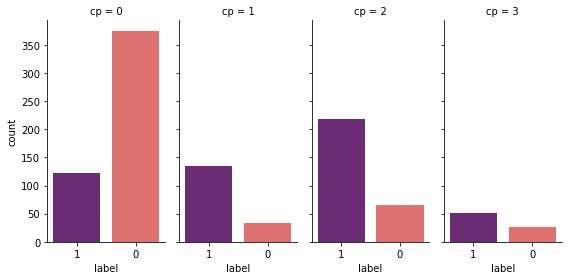

In [28]:
g = sns.FacetGrid(panda_df, col="cp", height=4,aspect=.5,hue='label',palette='magma_r')
g.map(sns.countplot, "label", order = panda_df['label'].value_counts().index)

The number of patients with heart attack in all levels of chest pain is greater than the number of patients without heart attack except for level zero. This means that this variable has an effect on heart attack.
We will explore whether this variable affects heart attack or not later

**Question:** What if we wanted to know who has the greatest chance of having a heart attack, women or men?
This is a Bernoulli distribution

### Bernoulli Distribution 
This distribution is related to Binary classification . (i.e What is the probability that this person is sick or not? Or what is the probability that this customer will buy the product or not and so on)

C:\Users\Abdelrhman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


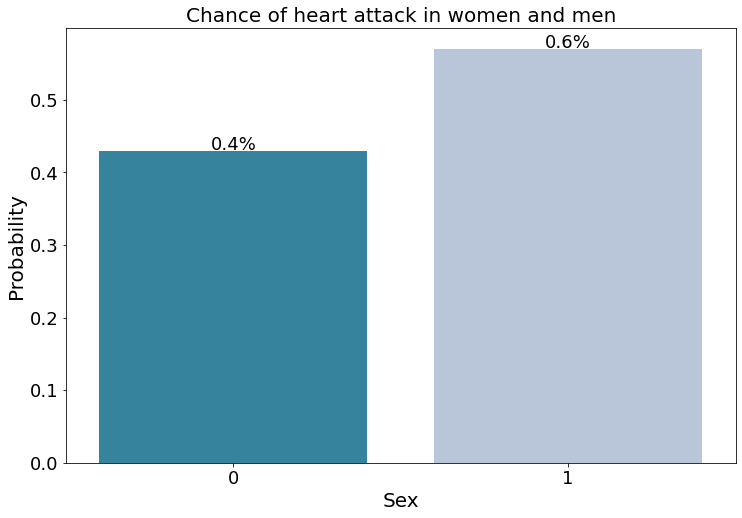

In [35]:
fig, ax = plt.subplots(figsize=(12,8))


# perform Bernoulli 
probabilities = heart_attack['sex'].value_counts(normalize=True)    
ax = sns.barplot(probabilities.index, probabilities.values, palette='PuBuGn_r')


# to write percentage on the top of bar 
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.001
    ax.annotate('{:.1f}%'.format(y), (x, y), ha='center' , fontsize = 18)


label_graph(18 ,'Sex' ,  'Probability'  , 'Chance of heart attack in women and men' ,  20 )

It's clear that men have a higher chance than women of having a heart attack, but we want to see more detail from our data to find out why.

Among the factors that we can look at if we are diagnosing a heart attack are:
- Blood pressure level 
- Cholesterol level 
- Blood sugar level

### Blood pressure level
> According to **Centers for Disease Control and Preventation (CDC)** , high blood pressure is a major risk factor for heart disease. It is a medical condition that happens when the pressure of the blood in your arteries and other blood vessels is too high. The high pressure, if not controlled, can affect your heart and other major organs of your body, including your kidneys and brain.
> - Some health care professionals diagnose patients with high blood pressure if their blood pressure is consistently 140/90 mm Hg or higher.2 This limit is based on a guideline released in 2003, as seen in the table below.
>
>
> - Other health care professionals diagnose patients with high blood pressure if their blood pressure is consistently 130/80 mm Hg or higher.1 This limit is based on a guideline released in 2017, as seen in the table below.

`trestbps` is an abbreviation for resting blood pressure

In [96]:
high_blood_pressure = heart_attack[heart_attack['trestbps'] > 130]
high_blood_pressure.sex.value_counts()

1    108
0     98
Name: sex, dtype: int64

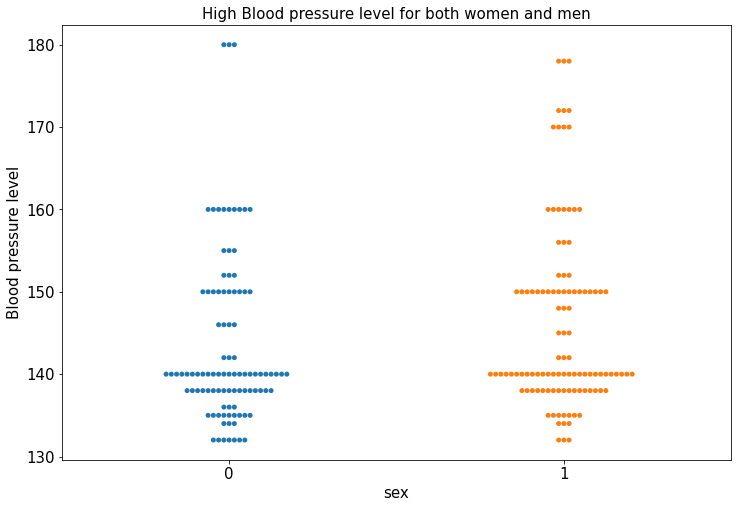

In [169]:
fig, ax = plt.subplots(figsize=(12,8))

# Generate plot
sns.swarmplot(x='sex' , y = 'trestbps' , data = high_blood_pressure)

#label axis
label_graph(15 ,'sex' ,  'Blood pressure level'  , 'High Blood pressure level for both women and men' ,  15 )

From the previous figure, women have a higher level of blood pressure than men, but the number of men who suffer from high blood pressure is greater than the number of women.

We can use another distribution to visualize our data

#### Cumulative distribution functions (CDFs) :
>**CDF** is another method to describe the distribution of continuous variables. The advantage of the CDF is that it can be defined for any kind of variable (discrete, continuous, and mixed).

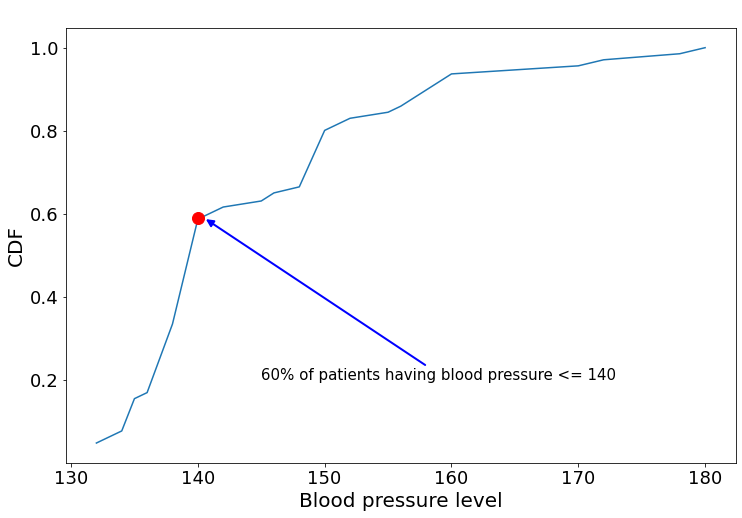

In [162]:
fig, ax = plt.subplots(figsize=(12,8))

cdf = Cdf.from_seq(high_blood_pressure['trestbps'])
cdf.plot()

ax.annotate("60% of patients having blood pressure <= 140 ", xy=(140.5, 0.59), xytext=(145, 0.2) , fontsize = 15 ,
            arrowprops={'arrowstyle': '-|>', 'lw': 2 , 'color' : 'b'})

plt.plot(140, 0.59 , marker = 'o' , color = 'r' , markersize = 12)

label_graph(18 ,'Blood pressure level' ,  'CDF'  , " " ,  20 )

- 20% of patients with a heart attack have a blood pressure < 140
- around 60% of patients with a heart attack have a blood pressure <= 140

### Cholesterol level
> According to **Centers for Disease Control and Preventation (CDC)** , Unhealthy blood cholesterol levels. Cholesterol is a waxy, fat-like substance made by the liver or found in certain foods. Your liver makes enough for your body’s needs, but we often get more cholesterol from the foods we eat.
>
>If we take in more cholesterol than the body can use, the extra cholesterol can build up in the walls of the arteries, including those of the heart. This leads to narrowing of the arteries and can decrease the blood flow to the heart, brain, kidneys, and other parts of the body

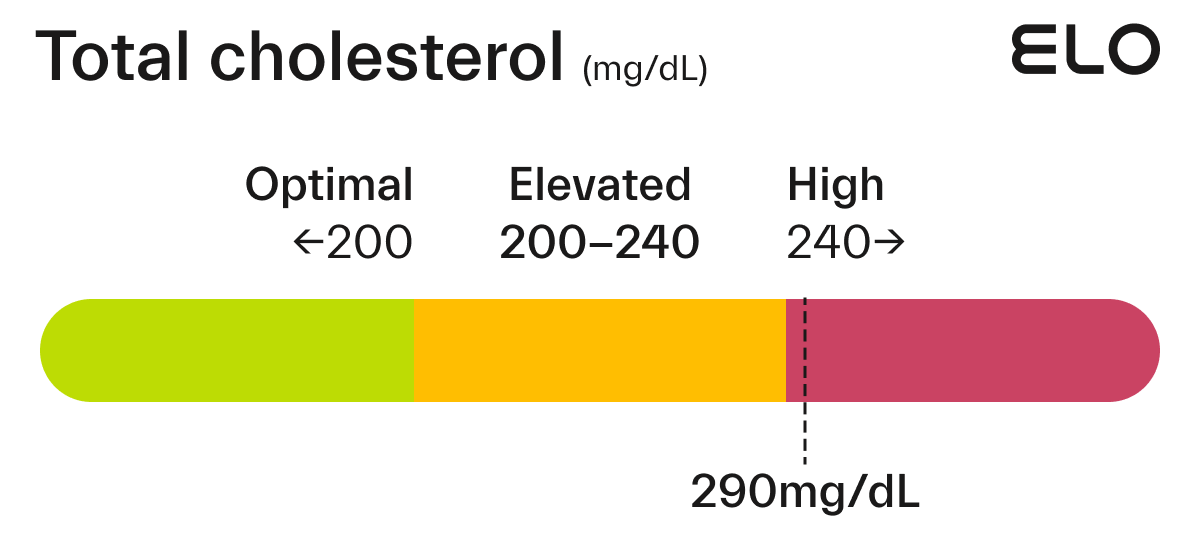

The high level of cholesterol in the blood does not quickly affect the heart, because the effect of cholesterol on the heart is in the long term, and therefore the high level of cholesterol does not cause us to worry at all. By consulting a doctor, taking treatment and eating healthy food, we can reduce this high level.
Unlike high blood pressure, which can quickly affect the heart

`chol` is serum cholestoral in mg/dl

In [51]:
#Calculating the number of people with high blood cholesterol
heart_attack_chol = panda_df[panda_df['chol'] > 240]
heart_attack_chol.groupby(['sex'])['label'].value_counts()

sex  label
0    1        123
     0         61
1    0        220
     1         99
Name: label, dtype: int64

#### Empirical Cumulative distribution Function (ECDF)

>What is **ECDF** ?
>
>The empirical CDF is a step function that asymptotically approaches 0 and 1 on the vertical Y-axis. It’s empirical because it represents your observed values and the corresponding data percentiles

In [78]:
  def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)
    
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y
  

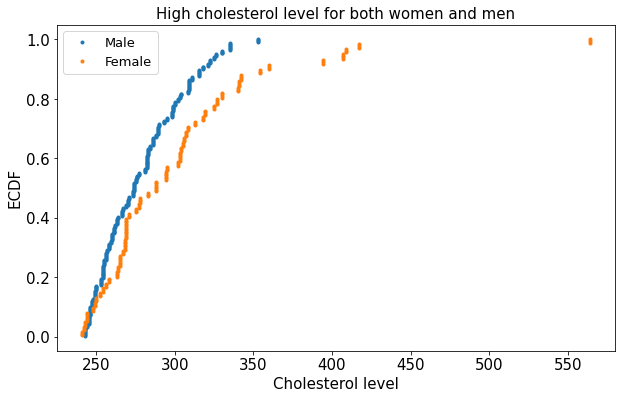

In [94]:
fig, ax = plt.subplots(figsize=(10,6))

heart_attack_m = heart_attack_chol[heart_attack_chol['sex'] == 1]
heart_attack_f = heart_attack_chol[heart_attack_chol['sex'] == 0]


m_chol, y_m = ecdf(heart_attack_m['chol'])
f_chol, y_f = ecdf(heart_attack_f['chol'])

# Generate plot
plt.plot(m_chol, y_m, marker='.', linestyle='none' , label = 'Male')
plt.plot(f_chol, y_f, marker='.', linestyle='none' , label = 'Female')

# Label the axes
plt.legend(fontsize = 13)
label_graph(15 ,'Cholesterol level' ,  'ECDF'  , 'High cholesterol level for both women and men' ,  15 )

From the previous figure, women have a higher level of cholesterol than men 

### Blood suger level 
>`fbs` is a fasting blood sugar > 120 mg/dl
>
>According to **Centers for Disease Control and Preventation (CDC)** , high blood sugar can damage blood vessels and the nerves that control your heart. **fasting blood sugar test** measures your blood sugar after an overnight fast (not eating). 
> - A fasting blood sugar level of 99 mg/dL or lower is normal
> - 100 to 125 mg/dL indicates you have prediabetes
> - and 126 mg/dL or higher indicates you have diabetes.
>
>According to **National Institute of Diabetes and Digestive and Kideny Diseases (NIDDK)** , Having diabetes means you are more likely to develop heart disease

In [60]:
fasting_blood_sugar = panda_df.groupby(['fbs'])['sex'].value_counts().unstack().fillna(0)
fasting_blood_sugar

sex,0,1
fbs,,
0,270,602
1,42,111


As we can see from this table there are :
- 42 women who have diabetes or prediabetes
- 111 men had diabetes or prediabetes

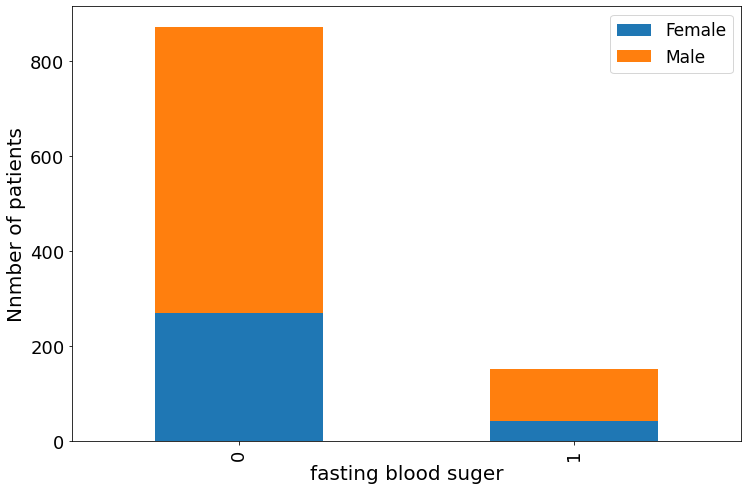

In [74]:
fasting_blood_sugar.plot(kind='bar', stacked=True , figsize=(12, 8))
label_graph(18 ,'fasting blood suger' ,  'Nnmber of patients' , None , 20 )
plt.legend(['Female' , 'Male'], fontsize = 17)


In [176]:
#Average age of the patients
heart_attack.groupby(['sex'])['age'].mean()

sex
0    54.628319
1    50.736667
Name: age, dtype: float64

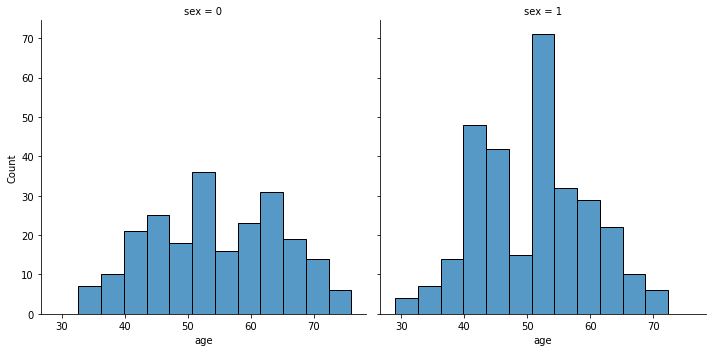

In [174]:
sns.displot(heart_attack, x="age", col="sex")

Almost all patients are women and men between the ages of 40 and 60

### Deteremine important factors

#### Chi Square distribution
if we want to see the correlation between two continuous numerical variables, we can either use visualizations or calculate Pearson's coefficient.

But what if we want to know the correlation between two categorical variables? In this case, we can use the chi-Square distribution

There are two types of Chi-Square :

- chi square test of independences 

- chi square goodness of fit test

We will use the first type to find out how related the two categorical variables are. Before we dive into this type

There are two types of Categorical variable :

**1- ordinal :** This type will be a rank such as your grades in exams or scientific degrees, i.e. a doctorate, master, bachelor or bachelor, and so on.

**2- nominal :** As for this type, it is any categorical variable such as gender, colors, types of dogs and cats, and so on
We use chi-Square with nominal categorical variables

to implement a Chi-Square test We need to define three things

**1- We define the hypothesis, i.e. we assume that the two variables are not correlated or independent of each other The first hypothesis is called Null hypothesis or H0 , We also determine the alternative hypothesis or H1 in the case of that the first hypothesis was false and in which we assume that the two variables are correlated**

**2- Determine the value of the alpha, and this value of alpha means the amount of error or risk allowed in the experiment. The value of the alpha is usually one of the following three values**

**3- calculate p-value and calculate this value by :**

- chi-Square Score

- The degree of freedom and the degree of freedom = (Number of column -1) * (Number of row -1 )


If p-vale is less than or equal to the value of the alpha that you specified previously , we will reject the H0 (Null hypothesis) and accept the H1 (Alternate hypothesis), meaning that the two variables are correlated.

And if p-value is greater than the value of alpha, we will accept the H0 (Null hypothesis) , and the two variables are independent of each other or not correlated.

In [181]:
def correlation(category):
    data_crosstab = pd.crosstab(panda_df[category] , panda_df['label'])
    alpha = 0.05

    chi_score, p, dof, expected = stats.chi2_contingency(data_crosstab)
    critical_value = stats.chi2.ppf(1-alpha , df = dof)

# chi square using p-value
    print("p value is " + str(p))
    if p <= alpha:
        print('Two categorical variables are correlated (Reject H0)')
    else:
        print('Two categorical variables are not correlated (Accept H0)')  

In [182]:
categories = ['sex' , 'cp' , 'fbs' , 'restecg' , 'exang' , 'slope' , 'ca']

for i in categories :
    print(i)
    correlation(i)
    print('_'*40)

sex

p value is 6.656820681726434e-19

Two categorical variables are correlated (Reject H0)

________________________________________

cp

p value is 1.2980664694820452e-60

Two categorical variables are correlated (Reject H0)

________________________________________

fbs

p value is 0.21862413102893974

Two categorical variables are not correlated (Accept H0)

________________________________________

restecg

p value is 1.6964251003877617e-08

Two categorical variables are correlated (Reject H0)

________________________________________

exang

p value is 2.8266374296634637e-44

Two categorical variables are correlated (Reject H0)

________________________________________

slope

p value is 1.421085239254566e-34

Two categorical variables are correlated (Reject H0)

________________________________________

ca

p value is 1.747013451046176e-54

Two categorical variables are correlated (Reject H0)

________________________________________


Except fbs variable, the rest of the variables are considered important factors

In [183]:
df = df.drop('fbs' , 'thal')

### Scaling data 
>in the machine learning algorithms if the values of the features are closer to each other there are chances for the algorithm to get trained well and faster instead of the data set where the data points or features values have high differences with each other will take more time to understand the data and the accuracy will be lower. 
So if the data in any conditions has data points far from each other, scaling is a technique to make them closer to each other or in simpler words, we can say that the scaling is used for making data points generalized so that the distance between them will be lower. There are many techniques to do scaling such as :
>- MinMax scaling
>- RobustScaler
>- Standardizations (we will use it in our project)
>- Normalize

### What is Standardizations ?

**Standardizations or Z-transforming** is the process of shifiting and scaling our data to better resemble a standard normal distribution, which has mean of 0 and standar deviation of 1  

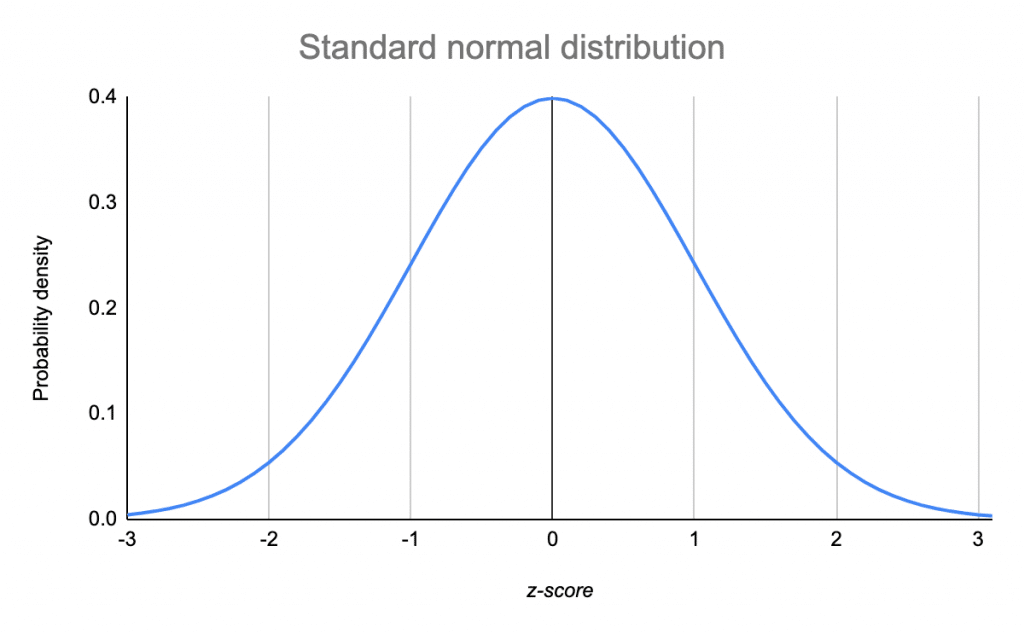

The equation of Standardizations is :

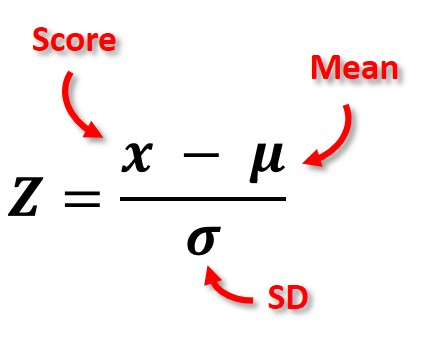

In [184]:
continuous_features = ['age' ,'trestbps', 'chol' , 'thalach' ,'oldpeak' ]
assembler1 = VectorAssembler(inputCols=continuous_features, outputCol="features_scaled1")
scaler = StandardScaler(inputCol="features_scaled1", outputCol="features_scaled")

In [185]:
assembler2 = VectorAssembler(inputCols=['sex', 'cp', 'restecg', 'slope', 'exang', 'ca','features_scaled'],
                             outputCol="features")

In [186]:
testDF, trainDF = df.randomSplit([0.3, 0.7])

In [187]:
lr = LogisticRegression(featuresCol="features" , labelCol='label' , maxIter=10, regParam= 0.01)

In [188]:
pipeline = Pipeline(stages= [assembler1 , scaler , assembler2 , lr])
# We fit the model using the training data.
pModel = pipeline.fit(trainDF)
# We transform the data.
Prediction = pModel.transform(testDF)
# # We select the actual label, probability and predictions
Prediction.select('label','probability','prediction').show()

+-----+--------------------+----------+

|label|         probability|prediction|

+-----+--------------------+----------+

|    1|[0.01436610719133...|       1.0|

|    1|[0.01436610719133...|       1.0|

|    1|[0.02388044103730...|       1.0|

|    1|[0.02388044103730...|       1.0|

|    1|[0.05677367728276...|       1.0|

|    1|[0.05677367728276...|       1.0|

|    0|[0.80763335782001...|       0.0|

|    0|[0.80763335782001...|       0.0|

|    1|[0.33379889614371...|       1.0|

|    0|[0.31448226057040...|       1.0|

|    1|[0.00493582040250...|       1.0|

|    1|[0.00493582040250...|       1.0|

|    1|[0.03164767401230...|       1.0|

|    0|[0.54661654646778...|       0.0|

|    0|[0.54661654646778...|       0.0|

|    0|[0.23160027956680...|       1.0|

|    1|[0.02800178548065...|       1.0|

|    1|[0.05570632436315...|       1.0|

|    1|[0.14176643373913...|       1.0|

|    1|[0.05532867785260...|       1.0|

+-----+--------------------+----------+

only showing top

In [189]:
evaluator = MulticlassClassificationEvaluator()
evaluator.evaluate(Prediction, {evaluator.metricName: 'accuracy'})

0.8445945945945946

### Conclusion :
- We have explored some of the data visually and explained some medical terminology
- After that, we identified the most important variables that could affect the heart attack prediction process
- Finally, we used an logistic regression algorithm to classify patients